<a href="https://colab.research.google.com/github/Tatfi32/TEST/blob/master/HJB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hijab/NON_Hijab Binary  Classification 

## Preliminary Set Up

### Google Disk connection

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from pathlib import Path
path = Path("/content/drive/My Drive/")
dest = path/"hijab"
dest.mkdir(parents=True, exist_ok=True)

In [3]:
% cd '/content/drive/My Drive/hijab'

/content/drive/My Drive/hijab


### Cloning dataset from github rep (hijab/nonhijab images) 

In [ ]:
# ! git clone https://github.com/najcardboyz/naja-dataset.git

In [ ]:
! ls

keras_plot_model.png  model.png  naja-dataset  test_keras_plot_model.png


## Dataset preliminary preparation

### Processed images from directories

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train = ImageDataGenerator(validation_split=0.25, rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

In [6]:
train_path = "/content/drive/My Drive/hijab/naja-dataset/dataset-2500/train/"
test_path = "/content/drive/My Drive/hijab/naja-dataset/dataset-2500/val/"

In [7]:
train_dataset = train.flow_from_directory(train_path,
                                          target_size=(150,150),
                                          batch_size = 50,
                                          color_mode="rgb",
                                          class_mode = 'binary',
                                          shuffle=True,
                                          subset='training')

val_dataset = train.flow_from_directory(train_path,
                                        target_size=(150,150),
                                        batch_size = 50,
                                        color_mode="rgb",
                                        class_mode = 'binary',
                                        shuffle=True,
                                        subset='validation')
                                         
test_dataset = test.flow_from_directory(test_path,
                                        target_size=(150,150),
                                        batch_size =50,
                                        color_mode="rgb",
                                        class_mode = 'binary',
                                        shuffle=False)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Dataset analysis

In [42]:
test_dataset.class_indices

{'hijab': 0, 'nonhijab': 1}

In [19]:
from matplotlib import pyplot as plt

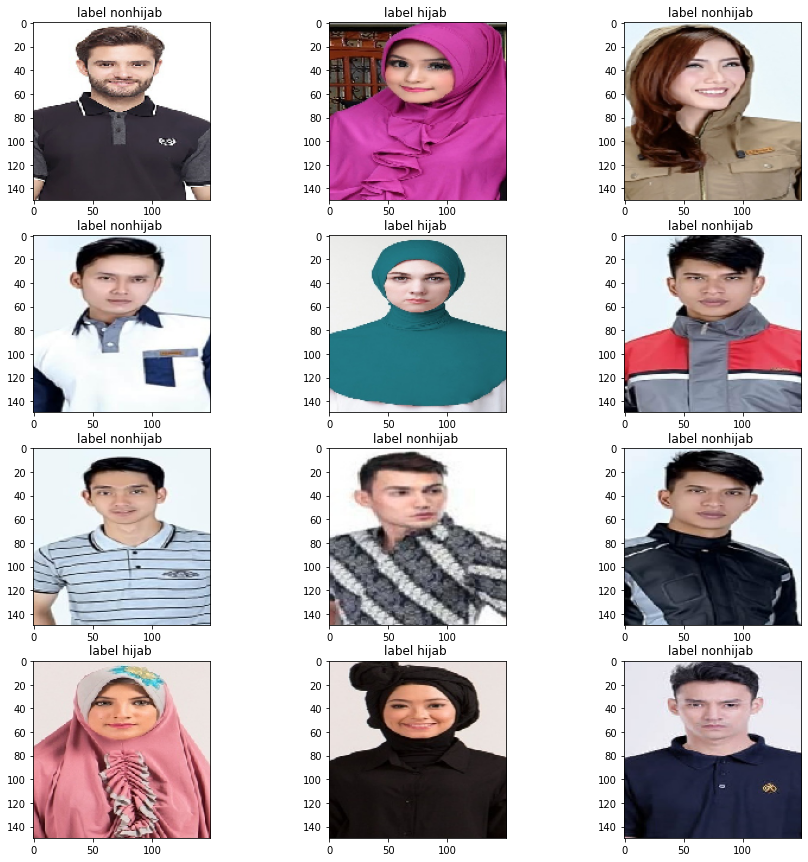

In [45]:
plt.figure(figsize=(15,15))
x,y = train_dataset.next()[:12]
for i in range(0,12):
    image = x[i]
    plt.subplot(4, 3, i+1)
    plt.imshow(image)
    if (y[i]) == 1:  
        plt.title("label nonhijab ")
    else: 
         plt.title("label hijab ")
plt.show()

In [43]:
labels = [train_dataset.labels, val_dataset.labels, test_dataset.labels]

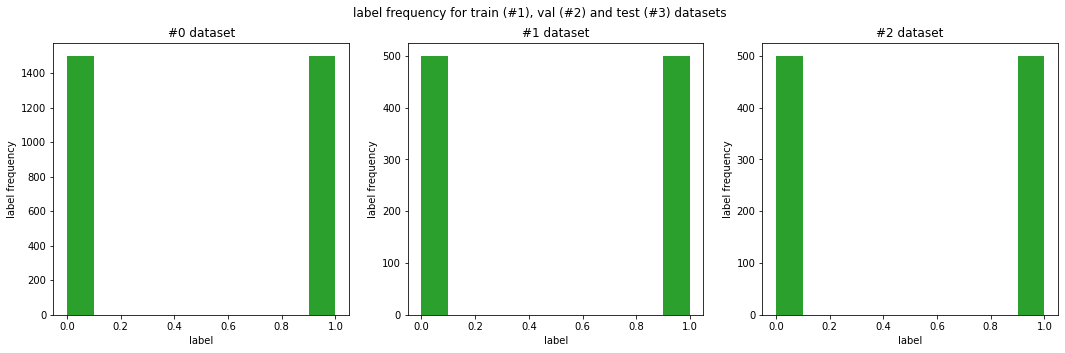

In [44]:
fig =  plt.figure(figsize=(18,5))
for i in range(len(labels)):
    plt.subplot(1,3,i+1)
    plt.title("#%d dataset"%(i))
    img = labels[i]
    plt.hist(img,color='C2')
    plt.xlabel("label")
    plt.ylabel("label frequency")
fig.suptitle("label frequency for train (#1), val (#2) and test (#3) datasets")
fig.show()

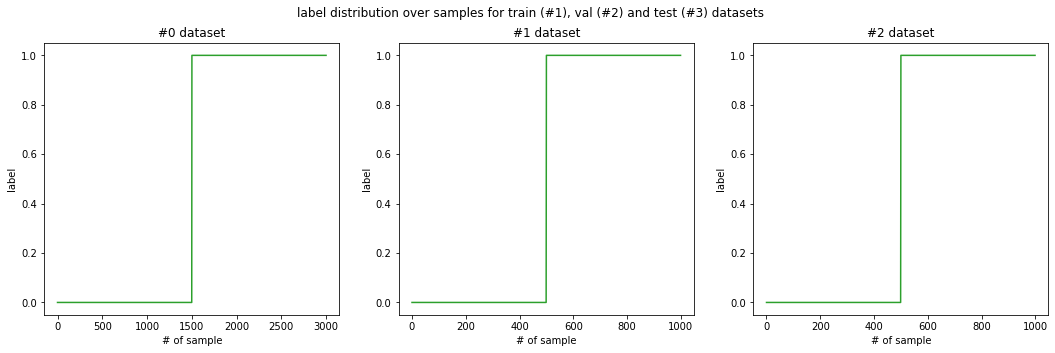

In [46]:
fig = plt.figure(figsize=(18,5))
for i in range(len(labels)):
    plt.subplot(1,3,i+1)
    plt.title("#%d dataset"%(i))
    label_data = labels[i]
    plt.plot(range(0,len(label_data)),label_data, color='C2')
    plt.xlabel("# of sample")
    plt.ylabel("label")
fig.suptitle("label distribution over samples for train (#1), val (#2) and test (#3) datasets")
fig.show()

## CNN Model 
Model from https://medium.com/techiepedia/binary-image-classifier-cnn-using-tensorflow-a3f5d6746697

### Defining CNN Model Layers

In [8]:
import tensorflow as tf
from tensorflow import keras

In [9]:
model = keras.Sequential()

# Convolutional layer and maxpool layer 1
model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(512,activation='relu'))

# Output layer with single neuron which gives 0 for one class or 1 for another
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1,activation='sigmoid'))

### Model structure overview

In [ ]:
 model.summary()

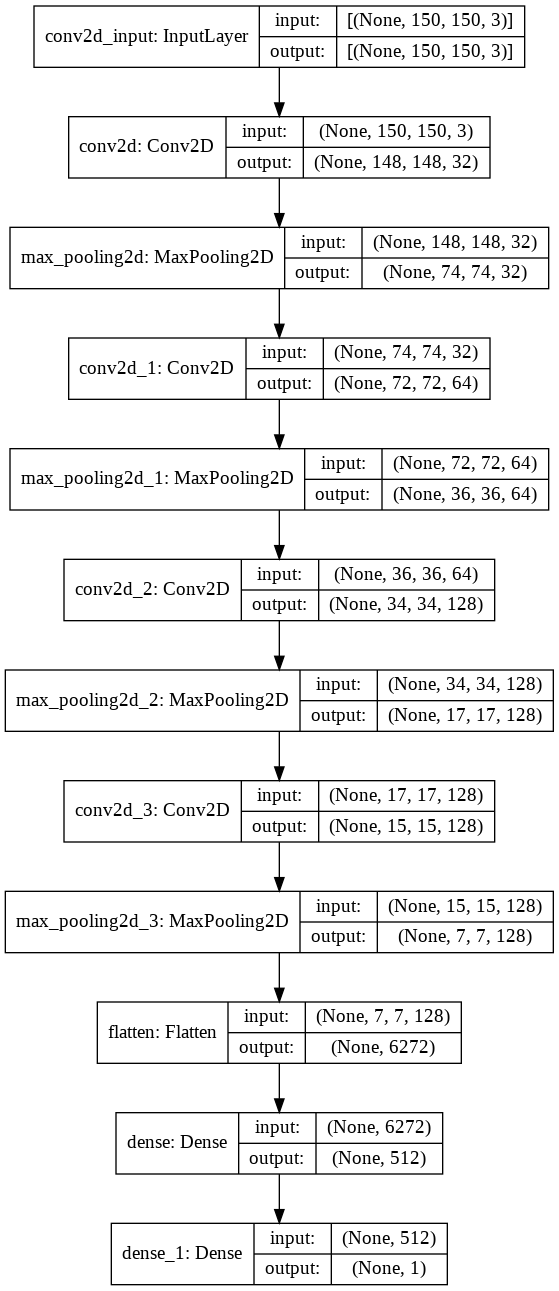

In [41]:
import IPython 
keras.utils.plot_model(model, to_file='keras_plot_model.png', show_shapes=True)
IPython.display.Image("keras_plot_model.png")

### Define training metrics

In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      ]

In [11]:
model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=METRICS)

In [12]:
checkpoint_filepath = '/content/drive/My Drive/hijab/naja-dataset/dataset-2500/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

### Fitting/Training the model

In [13]:
STEP_SIZE_TRAIN=train_dataset.n//train_dataset.batch_size
STEP_SIZE_VALID=val_dataset.n//val_dataset.batch_size

In [14]:
history =  model.fit_generator(
           generator = train_dataset,
           steps_per_epoch = STEP_SIZE_TRAIN,
           validation_data = val_dataset,
           validation_steps = STEP_SIZE_VALID,
           epochs = 8,
           callbacks=[model_checkpoint_callback],
           ) 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
60/60 [==============================] - 775s 13s/step - loss: 0.6085 - tp: 572.2951 - fp: 255.0656 - tn: 517.6230 - fn: 204.1967 - accuracy: 0.6483 - precision: 0.6417 - recall: 0.6949 - auc: 0.7297 - val_loss: 0.3691 - val_tp: 474.0000 - val_fp: 152.0000 - val_tn: 348.0000 - val_fn: 26.0000 - val_accuracy: 0.8220 - val_precision: 0.7572 - val_recall: 0.9480 - val_auc: 0.9555
Epoch 2/8
60/60 [==============================] - 145s 2s/step - loss: 0.2279 - tp: 706.3279 - fp: 63.5246 - tn: 704.2787 - fn: 75.0492 - accuracy: 0.9093 - precision: 0.9141 - recall: 0.9027 - auc: 0.9678 - val_loss: 0.1612 - val_tp: 462.0000 - val_fp: 20.0000 - val_tn: 480.0000 - val_fn: 38.0000 - val_accuracy: 0.9420 - val_precision: 0.9585 - val_recall: 0.9240 - val_auc: 0.9871
Epoch 3/8
60/60 [==============================] - 145s 2s/step - loss: 0.1359 - tp: 726.4426 - fp: 29.1639 - tn: 750.1803 - fn: 43.3934 - accuracy: 0.9521 - precision: 0.9621 - recall: 0.9402 - auc: 0.9887 - val_loss: 0.076

### Save and load model functions

In [15]:
#  model.save('/content/drive/My Drive/hijab/naja-dataset/dataset-2500/trained_model.h5')

In [ ]:
 # model.load_weights(checkpoint_filepath)

In [ ]:
# keras.models.load_model('/content/drive/My Drive/hijab/naja-dataset/dataset-2500/trained_model.h5')

### Plot a curve of classification metrics vs. epoch

In [16]:
def plot_curve(hist, list_of_metrics):
  """Plot a curve of classification metrics vs. epoch."""  
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(x[1:], label=m)
  plt.legend()

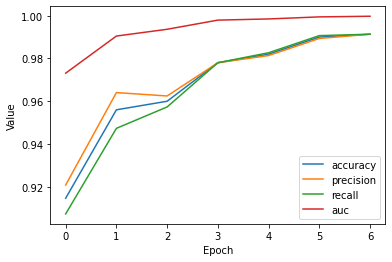

In [20]:
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'auc'] 
plot_curve( history.history, list_of_metrics_to_plot)

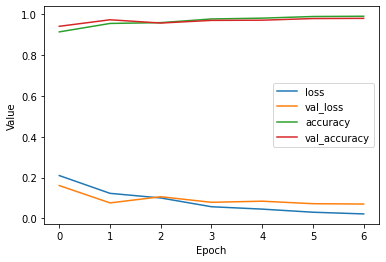

In [21]:
list_of_metrics_to_plot = ['loss', "val_loss", "accuracy", 'val_accuracy'] 
plot_curve(history.history, list_of_metrics_to_plot)

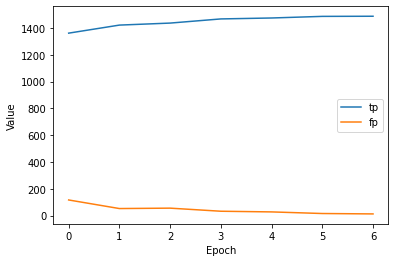

In [22]:
list_of_metrics_to_plot = ['tp','fp']
plot_curve( history.history, list_of_metrics_to_plot)

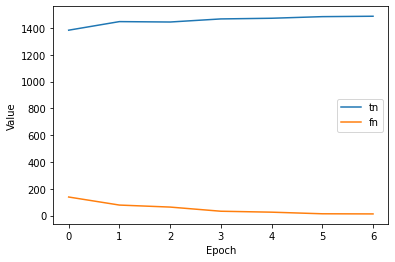

In [23]:
list_of_metrics_to_plot = ['tn','fn']
plot_curve( history.history, list_of_metrics_to_plot)

### Evaluate the model

In [24]:
results = model.evaluate_generator(
                     generator = val_dataset,
                     steps = STEP_SIZE_VALID)

for i in range(len(model.metrics_names)):
  print(model.metrics_names[i]," = ",results[i])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss  =  0.07064034044742584
tp  =  492.0
fp  =  11.0
tn  =  489.0
fn  =  8.0
accuracy  =  0.9810000061988831
precision  =  0.9781312346458435
recall  =  0.984000027179718
auc  =  0.9946861267089844


### Predict the output

In [25]:
STEP_SIZE_TEST=test_dataset.n//test_dataset.batch_size

test_dataset.reset()
pred=model.predict_generator(test_dataset,
                            steps=STEP_SIZE_TEST,
                            verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


20/20 [==============================] - 171s 9s/step


In [26]:
pred_bool = (pred >0.5)

In [27]:
predictions = pred_bool.astype(int)

## Results

### Confusion matrix

In [28]:
def plot_conf_matrix(cm, 
                    classes,
                    title='Confusion matrix',
                    cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

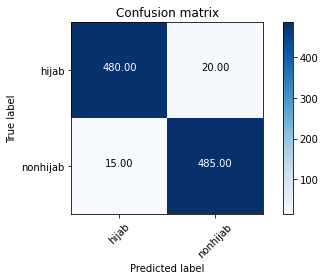

In [29]:
from sklearn.metrics import confusion_matrix 
import numpy as np
import itertools  

cnf_matrix = confusion_matrix(test_dataset.classes, predictions)
np.set_printoptions(precision=2)


plt.figure()
plot_conf_matrix(cnf_matrix, 
                classes=['hijab','nonhijab'],
                title='Confusion matrix')
plt.show()

### Classification_report

In [30]:
from sklearn.metrics import classification_report
report = classification_report(test_dataset.classes, predictions, target_names=['hijab','nonhijab'])
print(report)

              precision    recall  f1-score   support

       hijab       0.97      0.96      0.96       500
    nonhijab       0.96      0.97      0.97       500

    accuracy                           0.96      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.96      0.96      1000



### ROC Curve

In [37]:
pip install scikit-plot

In [38]:
import scikitplot

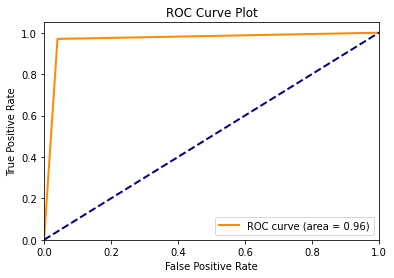

In [39]:
from sklearn.metrics import auc, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

fpr, tpr, _ = roc_curve(test_dataset.classes, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Plot')
plt.legend(loc="lower right")
plt.show()

### PRECISION-RECALL Curve

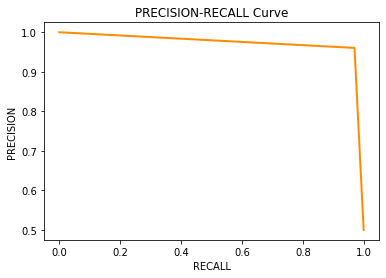

In [40]:
pre, rec, _ = precision_recall_curve(test_dataset.classes, predictions)
plt.plot(rec, pre,  color='darkorange',lw=lw)
plt.xlabel("RECALL")
plt.ylabel("PRECISION")
plt.title("PRECISION-RECALL Curve")
plt.show()